In [45]:
using Plots, LinearAlgebra, Statistics

In [46]:
pyplot()

Plots.PyPlotBackend()

# Cubic Spline Interpolator

In [12]:
function compute_interpolants( n::Int, f::Array{Float64})
        
    num_terms = 27
    
    coeffs = zeros(Float64,n+3)
    d      = zeros(Float64,n)

    a   = sqrt((2.0+sqrt(3.0))/6.0)
    r_a = 1.0/a
    b   = sqrt((2.0-sqrt(3.0))/6.0)
    b_a = b/a

    d1 = f[1]
    coeff_tmp = 1.0
    for i in 1:num_terms
        coeff_tmp *= (-b_a)
        d1 += coeff_tmp*f[n-i]
    end

    d[1] = d1*r_a
    for i in 2:n-1
        d[i] = r_a*(f[i] - b*d[i-1])
    end
        
    d1        = d[n-1]
    coeff_tmp = 1.0
    for i in 1:num_terms
        coeff_tmp *= (-b_a)
        d1 += coeff_tmp*d[i]
    end

    coeffs[n] = d1*r_a
    
    for i in n-2:-1:1
        coeffs[i+1] = r_a*(d[i] - b*coeffs[i+2])
    end

    coeffs[1]   = coeffs[n]
    coeffs[n+1] = coeffs[2]
    coeffs[n+2] = coeffs[3]
    coeffs[n+3] = coeffs[4]
    coeffs
end

compute_interpolants (generic function with 1 method)

In [25]:
function interpolate( coeffs::Array{Float64,1}, n::Int,
    xmin::Float64, xmax::Float64, x::Float64 ) 
        
    rh  = (n-1) / (xmax - xmin)
    
    t0      = (x-xmin)*rh
    cell    = floor(Int, t0)+1
    dx      = t0 - (cell-1)
    cdx     = 1.0 - dx
    icell   = floor(Int,cell)
    cim1    = coeffs[icell]
    ci      = coeffs[icell+1]
    cip1    = coeffs[icell+2]
    cip2    = coeffs[icell+3]
    t1      = 3.0*ci
    t3      = 3.0*cip1
    t2      = cdx*(cdx*(cdx*(cim1 - t1) + t1) + t1) + ci
    t4      =  dx*( dx*( dx*(cip2 - t3) + t3) + t3) + cip1
            
    return (t2 + t4) / 6.0
end

interpolate (generic function with 1 method)

## Interpolation test

In [42]:
n = 30
xmin, xmax = 0.0,1.0
x = collect(range(xmin,stop=xmax,length=n))
y = sin.(x.*2*pi)
x_new = zeros(Float64,n)
y_new = zeros(Float64,n)
coeffs = compute_interpolants(n, y) # compute spline coefficients
for (i, xi) in enumerate(x)
    x_new[i] = xi + 0.1   # x displacement of 0.1
    x_new[i] = xmin + ( x_new[i] - xmin)%(xmax-xmin) # apply periodic boundary conditions
    y_new[i] = interpolate(coeffs, n, xmin, xmax, x_new[i])
end

In [43]:
x

30-element Array{Float64,1}:
 0.0                 
 0.034482758620689655
 0.06896551724137931 
 0.10344827586206896 
 0.13793103448275862 
 0.1724137931034483  
 0.20689655172413793 
 0.2413793103448276  
 0.27586206896551724 
 0.3103448275862069  
 0.3448275862068966  
 0.3793103448275862  
 0.41379310344827586 
 ⋮                   
 0.6206896551724138  
 0.6551724137931034  
 0.6896551724137931  
 0.7241379310344828  
 0.7586206896551724  
 0.7931034482758621  
 0.8275862068965517  
 0.8620689655172413  
 0.896551724137931   
 0.9310344827586207  
 0.9655172413793104  
 1.0                 

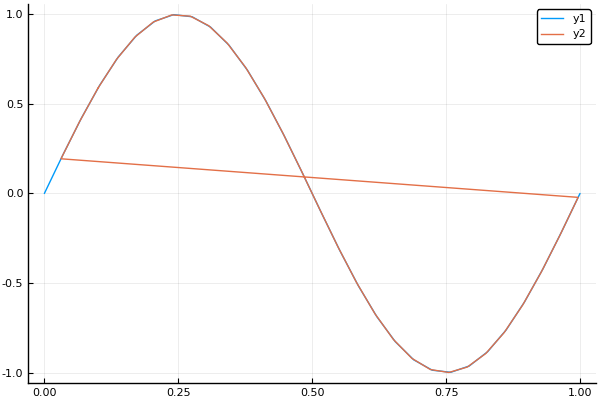

In [44]:
plot(x, y)
plot!(x_new, y_new)

In [41]:
@cython.boundscheck(False)
def advection_x(np.ndarray [dtype_t, ndim=2] f, 
                np.ndarray [dtype_t, ndim=1] x,
                int nv, int nx, 
                double xmin, double xmax, 
                np.ndarray [dtype_t, ndim=1] v,
                double dt):
    
    cdef double[:] coeffs
    cdef double x_new
    cdef Py_ssize_t i, j

    for j in range(nv):
        coeffs = compute_interpolants(nx, f[j,:])        
        for i in range(nx):
            x_new = x[i] - dt * v[j]
            x_new = xmin + ( x_new - xmin)%(xmax-xmin)
            f[j,i] = interpolate(coeffs, nx, xmin, xmax, x_new)
    return f

@cython.boundscheck(False)
def advection_v(np.ndarray [dtype_t, ndim=2] f, 
                np.ndarray [dtype_t, ndim=1] v, 
                int nx, int nv, 
                double vmin, double vmax, 
                double[:] e, 
                double dt):
    
    cdef double[:] coeffs 

    cdef Py_ssize_t i, j
    cdef double v_new
    for i in range(nx):
        coeffs = compute_interpolants(nv, f[:,i] )       
        for j in range(nv):
            v_new = v[j] - dt * e[i] 
            v_new = vmin + (v_new - vmin)%(vmax-vmin) #(b + (a%b)) % b
            f[j,i] = interpolate(coeffs, nv, vmin, vmax, v_new)
    return f
            

LoadError: UndefVarError: cython not defined

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$





In [18]:
import progressbar
from scipy.fftpack import fft, ifft

class VlasovPoisson: # Backward Semi-Lagragian 
     
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv):
        
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, retstep=True )
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, retstep=True)

        self.f = np.zeros((nx,nv))
            
        # Modes for Poisson equation
        self.modes = np.zeros(nx)
        k =  2* np.pi / (xmax - xmin)
        self.modes[:nx//2] = k * np.arange(nx//2)
        self.modes[nx//2:] = - k * np.arange(nx//2,0,-1)
        self.modes += self.modes == 0 # avoid division by zero 
        self.xmin = xmin
        self.xmax = xmax
        self.vmin = vmin
        self.vmax = vmax
        
        self.interp_x = np.vectorize(interpolate)
        self.interp_v = np.vectorize(interpolate)

    def advection_x(self, dt):
        
        self.f = advection_x( self.f, self.x, self.nv, self.nx, 
                             self.xmin, self.xmax, self.v, dt)

    def advection_v(self, e, dt):
        
        self.f = advection_v(self.f, self.v, self.nx, self.nv, 
                             self.vmin, self.vmax, e, dt)
            
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=0)
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = fft(rho)/self.modes
        return np.real(ifft(-1j*rhok))
    
    def run(self, f, nstep, dt):
        nrj = []
        self.f = f
        self.advection_x(0.5*dt)
        bar = progressbar.ProgressBar()
        for istep in bar(range(nstep)):
            rho = self.compute_rho()
            e = self.compute_e(rho)
            self.advection_v(e, dt)
            self.advection_x(dt)
            nrj.append( 0.5*np.log(np.sum(e*e)*self.dx))
            
        return nrj

# Bump On Tail

In [19]:
alpha = 0.03
kx  = 0.3
n = 1
Lx = 2 * np.pi * n / kx
sim = VlasovPoisson(xmin = 0.0, xmax = Lx, 
                    nx = 512,
             vmin = -9., vmax = 9., nv = 512)

X, V = np.meshgrid(sim.x, sim.v)

f = (1.0+alpha*np.cos(kx*X)) / (10*np.sqrt(2*np.pi))
f *= (9*np.exp(-0.5*V*V)+2*np.exp(-2*(V-4.5)**2))


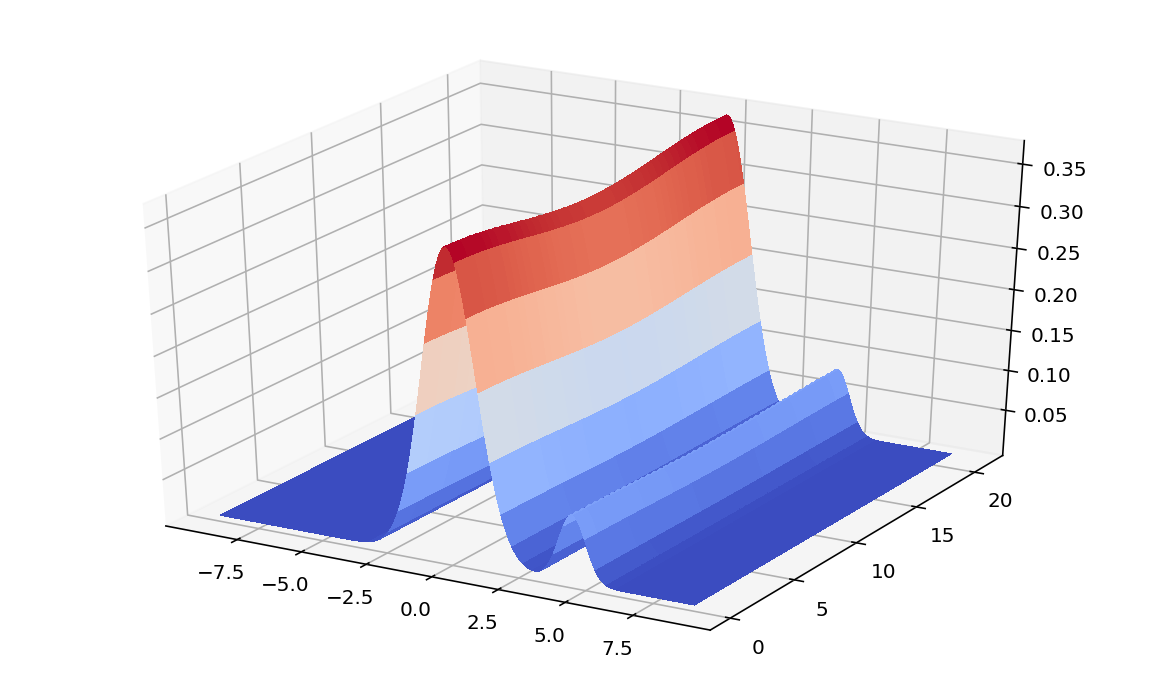

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(V, X, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


100% (500 of 500) |#######################| Elapsed Time: 0:00:17 Time: 0:00:17


CPU times: user 17.2 s, sys: 3.06 s, total: 20.3 s
Wall time: 17.9 s


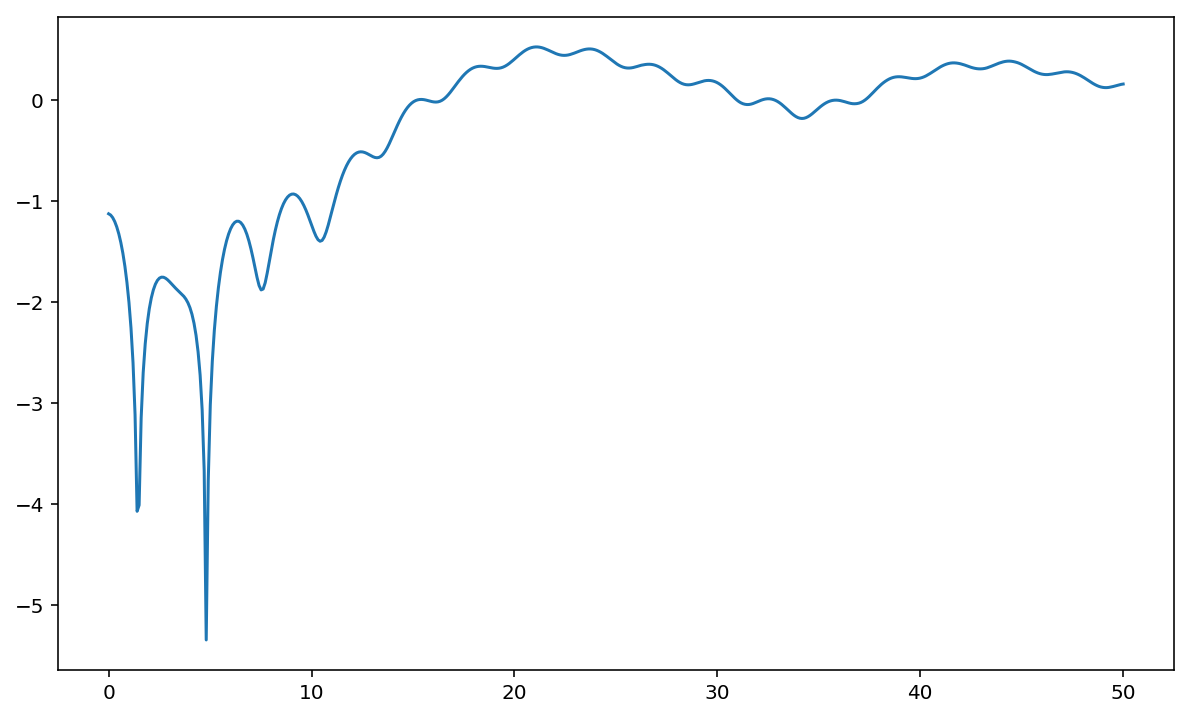

In [21]:
%%time
nstep = 500
t, dt = np.linspace(0.0, 50.0, nstep, retstep=True)
nrj = sim.run( f, nstep, dt)

plt.plot(t, nrj)